In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii


In [2]:
#Bruno's github codes

def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}


def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return


#amended code

def select_object_segmap(segmap,index):
    Regions = np.zeros_like(segmap)
    if index not in segmap:
        raise ValueError('index not in segmentation map')
    Regions[segmap==index]=index
    return Regions

In [3]:
masterdata = ascii.read('/data1/rowland/mastertable')
#masterdata

In [4]:
# for count,i in enumerate(masterdata['NUMBER_F105']):
#     print(count,i)

In [ ]:
#testing



# #segmap = segmap_file[0].data+0 #PARAMETER
# collected_regions = []
# master_filters = ["F105","F125","F140","F160","F435","F606","F625","F775","F814","F850"]



# for filter in master_filters:
#     if filter is not 'F850': #need this b/c table colnames arent full filternames
#         filtername = filter + 'W'
#     else:
#         filtername = filter + 'LP'
#     segmap = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filtername))[0].data
#     print(segmap.shape)
#     #print(filtername)
#     for detection in masterdata: 

#         #print(detection)
#         xc = detection["X_IMAGE_{}".format(filter)] #in pix #PARAMETER
#         yc = detection["Y_IMAGE_{}".format(filter)] #in pix #PARAMETER
#         #print(xc,yc)
#         pixscale = 0.06 #PARAMETER
#         index = detection['NUMBER_{}'.format(filter)]
#         #print(index.dtype)
#         radius=0.5 ##DEFAULT value for reference #PARAMETER
#         if index.dtype == 'int64':
#             #print('chose this path')
#             each_region = select_object_segmap(segmap,index) #indexing so have matching value so subtracting =0
#         else:
#             #print('chose that path')
#             pass
#         collected_regions.append(each_region)
#     break
# collected_regions = np.array(collected_regions)
# print('collected_regions: type-',type(collected_regions), 'shape-',collected_regions.shape)    
# final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
# print('shape of final regions:',final_regions.shape)

(4824, 4538)


In [4]:
#think gotta make a fcn b/c cant save indiv filter collected regions another way


def regions(filtername):
    collected_regions = []
    masterdata = ascii.read('/data1/rowland/mastertable')
    segmap = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filtername))[0].data
        #print(segmap.shape)
        #print(filtername)
    for detection in masterdata: 
        if filtername is not 'F850LP': #need this b/c table colnames arent full filternames
            filter = filtername[:-1]
            #print('chose this path:',filter)
        else:
            filter = filtername[:-2]
            #print('chose that path:',filter)
        #print(detection)
        xc = detection["X_IMAGE_{}".format(filter)] #in pix #PARAMETER
        yc = detection["Y_IMAGE_{}".format(filter)] #in pix #PARAMETER
        #print(xc,yc)
        pixscale = 0.06 #PARAMETER
        index = detection['NUMBER_{}'.format(filter)]
        #print(index.dtype)
        radius=0.5 ##DEFAULT value for reference #PARAMETER
        if index.dtype == 'int64':
            #print('chose this path')
            each_region = select_object_segmap(segmap,index) #indexing so have matching value so subtracting =0
        else:
            #print('chose that path')
            pass
    collected_regions.append(each_region)
    return(collected_regions)
# collected_regions = np.array(collected_regions)
# print('collected_regions: type-',type(collected_regions), 'shape-',collected_regions.shape)    
# final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
# print('shape of final regions:',final_regions.shape)

In [15]:
#regions_F105 = regions('F850LP')

In [16]:
#np.shape(regions_F105)

(1, 8473, 8201)

# Doing one step at a time to verify works, combine steps later

In [5]:
#runs through each filter to get regions for each

filters = ["F105W","F125W","F140W","F160W","F435W","F606W","F625W","F775W","F814W","F850LP"]

allregions = []
for filter in filters:
    eachregion = regions(filter)
    allregions.append(eachregion)
np.shape(allregions)

(10, 1)

In [7]:
#how to index/separate each filters info


#np.shape(allregions[3][0]) #change first index to go through each region

(4824, 4538)

In [35]:
#testing how to sum these to create mask PER FILTER

# collected_regions = np.array(collected_regions)
# print('collected_regions: type-',type(collected_regions), 'shape-',collected_regions.shape)    
# final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
# print('shape of final regions:',final_regions.shape)

for arr in allregions:
    print(np.shape(arr))

(1, 4824, 4538)
(1, 4824, 4538)
(1, 4824, 4538)
(1, 4824, 4538)
(1, 4256, 4397)
(1, 8473, 8201)
(1, 8473, 8201)
(1, 8473, 8201)
(1, 8473, 8201)
(1, 8473, 8201)


In [6]:
finalregions=[]

for arr in allregions:
    finalregion = np.sum(arr,axis=0)
    finalregions.append(finalregion)
np.shape(finalregions[0])

(4824, 4538)

In [39]:
masks=[]
for count,filter in enumerate(filters):
    segmap = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filter))[0].data
    mask = segmap - finalregions[count]
    masks.append(mask)
np.shape(masks) #one mask per filter

(10,)

In [40]:
finalmasks = []

for count,filter in enumerate(filters):
    masks[count][np.where(masks[count] > 0)]=1
    image_data = pyfits.open('/data1/rowland/elgordo_{}.fits'.format(filter))[0].data
    masks[count][image_data==0]=1
    finalmasks.append(masks)
np.shape(finalmasks)

(10, 10)

In [42]:
np.shape(finalmasks[0][0])

(4824, 4538)

In [48]:
np.shape(finalregions[0])

(4538,)

In [44]:
image_dataF105 = pyfits.open('/data1/rowland/elgordo_F105W.fits')[0].data
segmapF105 = pyfits.open('/data1/rowland/segmaps_check/F105W_check.fits')[0].data

x = masterdata['X_IMAGE_F105'][0]
y = masterdata['Y_IMAGE_F105'][0]

TypeError: Invalid dimensions for image data

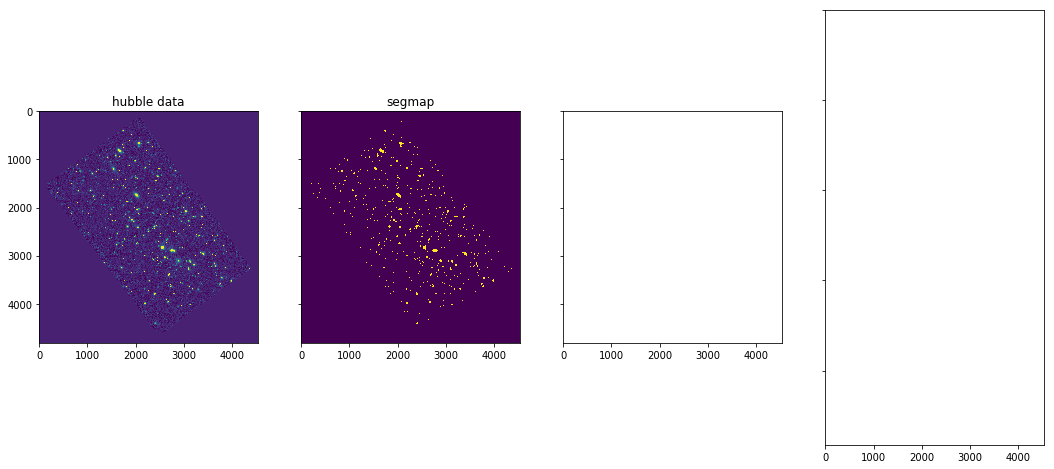

In [46]:


fig, axis = mpl.subplots(1,4,figsize=(18,8),sharex=True,sharey=True)
axis[0].imshow(image_dataF105,vmin = -0.01,vmax = 0.1)
axis[0].set_title('hubble data')
axis[1].imshow(segmapF105,vmin=0,vmax=1)
axis[1].set_title('segmap')
axis[2].imshow(finalregions[0][0],vmin=0, vmax=1)
axis[2].set_title('detected regions')
axis[3].imshow(finalmasks[0],vmin=0,vmax=1)
axis[3].set_title('mask')

for ax in axis:
    #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
    w = 250
    ax.set_xlim(x-w,x+w)
    ax.set_ylim(y-w,y+w)